# **Assignment-4**
# **Facenet**
Facenet implementation by Keras.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

- Use a pretrained model to map face images
- Use embeddings to perform face verification and face recognition




In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Import Libraries**

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [0]:
cascade_path = '/content/drive/My Drive/297-98_SpecialTopics/Facenet/haarcascade_frontalface_alt2.xml'

In [0]:
image_dir_basepath = '/content/drive/My Drive/297-98_SpecialTopics/Facenet/images/'
names = ['LarryPage', 'MarkZuckerberg', 'BillGates']
image_size = 160

In [5]:
model_path = '/content/drive/My Drive/297-98_SpecialTopics/Facenet/facenet_keras.h5'
model = load_model(model_path)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [0]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [0]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [0]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))

In [0]:
data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

1.371488094329834


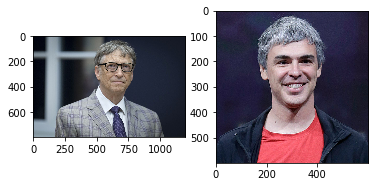

In [11]:
calc_dist_plot('BillGates0', 'LarryPage0')

0.5091050863265991


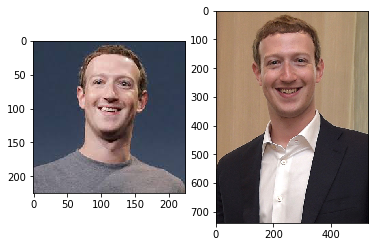

In [12]:
calc_dist_plot('MarkZuckerberg0', 'MarkZuckerberg1')

## **Plotting**

In [0]:
X = []
for v in data.values():
    X.append(v['emb'])
pca = PCA(n_components=3).fit(X)

In [0]:
X_BillGates = []
X_LarryPage = []
X_MarkZuckerberg = []
for k, v in data.items():
    if 'Bill' in k:
        X_BillGates.append(v['emb'])
    elif 'Larry' in k:
        X_LarryPage.append(v['emb'])
    elif 'Mark' in k:
        X_MarkZuckerberg.append(v['emb'])
        
Xd_BillGates = pca.transform(X_BillGates)
Xd_LarryPage = pca.transform(X_LarryPage)
Xd_MarkZuckerberg = pca.transform(X_MarkZuckerberg)

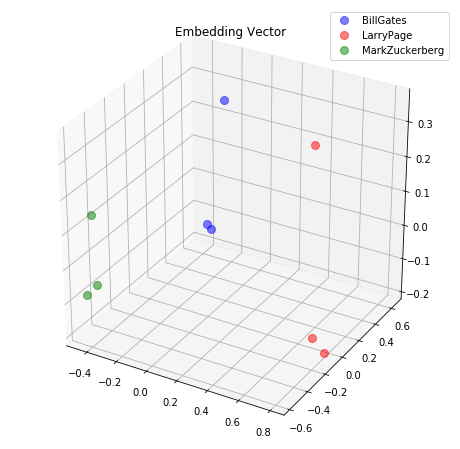

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(Xd_BillGates[:,0], Xd_BillGates[:,1], Xd_BillGates[:,2],
        'o', markersize=8, color='blue', alpha=0.5, label='BillGates')
ax.plot(Xd_LarryPage[:,0], Xd_LarryPage[:,1], Xd_LarryPage[:,2],
        'o', markersize=8, color='red', alpha=0.5, label='LarryPage')
ax.plot(Xd_MarkZuckerberg[:,0], Xd_MarkZuckerberg[:,1], Xd_MarkZuckerberg[:,2],
        'o', markersize=8, color='green', alpha=0.5, label='MarkZuckerberg')

plt.title('Embedding Vector')
ax.legend(loc='upper right')

plt.show()
